In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
# import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.layers import Dropout, GRU, Dense, Conv1D, Conv2D, Flatten
from keras.models import Sequential
import matplotlib.pyplot as plt

# Set up plot style
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

2024-08-26 08:44:43.707292: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# Helper Functions for Technical Indicators
def SMA(df, window_size):
    """
    Calculate the Simple Moving Average (SMA) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing at least the 'Close' column.
    window_size (int): The window size for calculating the SMA.
    
    Returns:
    Series: The SMA values.
    """
    return df['Close'].rolling(window=window_size).mean()

def EMA(df, window_size):
    """
    Calculate the Exponential Moving Average (EMA) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing at least the 'Close' column.
    window_size (int): The window size for calculating the EMA.
    
    Returns:
    Series: The EMA values.
    """
    return df['Close'].ewm(span=window_size).mean()

def MACD(df, short_window, long_window):
    """
    Calculate the Moving Average Convergence Divergence (MACD) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing at least the 'Close' column.
    short_window (int): The window size for the short EMA.
    long_window (int): The window size for the long EMA.
    
    Returns:
    Series: The MACD values.
    """
    short_EMA = EMA(df, short_window)
    long_EMA = EMA(df, long_window)
    return short_EMA - long_EMA

def RSI(df, window_size):
    """
    Calculate the Relative Strength Index (RSI) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing at least the 'Close' column.
    window_size (int): The window size for calculating the RSI.
    
    Returns:
    Series: The RSI values.
    """
    delta = df['Close'].diff()
    delta = delta[1:] 
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=window_size - 1, min_periods=window_size).mean()
    ema_down = down.ewm(com=window_size - 1, min_periods=window_size).mean()
    return ema_up / ema_down

def Bollinger_Bands(df, window_size):
    """
    Calculate the Bollinger Bands for the given df.
    
    Parameters:
    df (dfFrame): The input df containing at least the 'Close' column.
    window_size (int): The window size for calculating the Bollinger Bands.
    
    Returns:
    Tuple[Series, Series]: The upper and lower Bollinger Bands.
    """
    middle_band = SMA(df, window_size)
    std_dev = df['Close'].rolling(window=window_size).std()
    upper_band = middle_band + (std_dev * 2)
    lower_band = middle_band - (std_dev * 2)
    return upper_band, lower_band

def create_sequences(df, seq_length):
    """
    Create sequences of df for time series forecasting.
    
    Parameters:
    df (dfFrame): The input df.
    seq_length (int): The length of each sequence.
    
    Returns:
    Tuple[np.ndarray, np.ndarray]: Arrays of input sequences and corresponding targets.
    """
    xs = []
    ys = []
    
    for i in range(len(df) - seq_length - 1):
        x = df.iloc[i:(i + seq_length)].values
        y = df.iloc[(i + seq_length)]['Close']
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)

def gain(x):
    """
    Calculate the gain from an array of differences.
    
    Parameters:
    x (np.ndarray): The array of differences.
    
    Returns:
    float: The total gain.
    """
    return ((x > 0) * x).sum()

def loss(x):
    """
    Calculate the loss from an array of differences.
    
    Parameters:
    x (np.ndarray): The array of differences.
    
    Returns:
    float: The total loss.
    """
    return ((x < 0) * x).sum()

def MFI(df, n=14):
    """
    Calculate the Money Flow Index (MFI) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing 'High', 'Low', 'Close', and 'Volume' columns.
    n (int): The window size for calculating the MFI.
    
    Returns:
    np.ndarray: The MFI values.
    """
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['Volume']
    typical_price = (high + low + close) / 3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw=True)
    return (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()

def ATR(df, n=14):
    """
    Calculate the Average True Range (ATR) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing 'High', 'Low', and 'Close' columns.
    n (int): The window size for calculating the ATR.
    
    Returns:
    np.ndarray: The ATR values.
    """
    high = df['High']
    low = df['Low']
    close = df['Close']
    tr = np.amax(np.vstack(((high - low).to_numpy(), (abs(high - close)).to_numpy(), (abs(low - close)).to_numpy())).T, axis=1)
    return pd.Series(tr).rolling(n).mean().to_numpy()

def ForceIndex(df, ndays): 
    """
    Calculate the Force Index for the given df.
    
    Parameters:
    df (dfFrame): The input df containing 'Close' and 'Volume' columns.
    ndays (int): The window size for calculating the Force Index.
    
    Returns:
    dfFrame: The df with the Force Index column added.
    """
    FI = pd.Series(df['Close'].diff(ndays) * df['Volume'], name='ForceIndex')
    df = df.join(FI)
    return df

def EMV(df, ndays): 
    """
    Calculate the Ease of Movement (EMV) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing 'High', 'Low', and 'Volume' columns.
    ndays (int): The window size for calculating the EMV.
    
    Returns:
    dfFrame: The df with the EMV column added.
    """
    dm = ((df['High'] + df['Low']) / 2) - ((df['High'].shift(1) + df['Low'].shift(1)) / 2)
    br = (df['Volume'] / 100000000) / (df['High'] - df['Low'])
    EMV = dm / br 
    EMV_MA = pd.Series(EMV.rolling(ndays).mean(), name='EMV')
    df = df.join(EMV_MA)
    return df

def add_lags(df):
    """
    Add lagged features to the DataFrame for various time periods.

    Parameters:
    df (DataFrame): The input DataFrame with at least 'High', 'Low', 'Open', and 'Close' columns.

    Returns:
    DataFrame: The DataFrame with added lagged features for day, week, month, quarter, and year.
    """
    df['lag day high'] = df['High'].shift(1)
    df['lag day low'] = df['Low'].shift(1)
    df['lag day open'] = df['Open'].shift(1)
    df['lag day close'] = df['Close'].shift(1)
    df['lag week close'] = df['Close'].shift(5)
    df['lag month close'] = df['Close'].shift(20)
    df['lag quarter close'] = df['Close'].shift(60)
    df['lag year close'] = df['Close'].shift(252)
    return df

def create_time_features(df):
    """
    Create time-based features from the DataFrame index, which should be a datetime index.

    Parameters:
    df (DataFrame): The input DataFrame with a datetime index.

    Returns:
    DataFrame: The DataFrame with added time-based features such as day of the week, month, quarter, etc.
    """
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

def make_3D(data, seq_length, features, target):
    """
    Transform the data into 3D format suitable for LSTM/GRU models by creating sequences.

    Parameters:
    data (DataFrame): The input DataFrame.
    seq_length (int): The length of the input sequences.
    features (list): List of feature column names to be included in each sequence.
    target (str): The target column name.

    Returns:
    Tuple[np.ndarray, np.ndarray]: 3D numpy arrays for input sequences (X) and corresponding targets (y).
    """
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)][features].values
        y = data.iloc[i + seq_length][target]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Data Preparation
def load_and_prepare_data(file_path):
    """
    Load the data from a CSV file, compute technical indicators and time-based features, 
    and prepare it for modeling.

    Parameters:
    file_path (str): The file path to the CSV data.

    Returns:
    DataFrame: The prepared DataFrame with technical indicators and time-based features.
    """
    df = pd.read_csv(file_path)
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)
    df = add_lags(df)
    df['SMA'] = SMA(df, 14)
    df['EMA'] = EMA(df, 14)
    df['MACD'] = MACD(df, 12, 26)
    df['RSI'] = RSI(df, 14)
    df['Upper_band'], df['Lower_band'] = Bollinger_Bands(df, 14)
    df['MFI'] = MFI(df, 14)
    df['ATR'] = ATR(df, 14)
    df['ForceIndex'] = ForceIndex(df, 14)['ForceIndex']
    df['EMV'] = EMV(df, 14)['EMV']
    df = create_time_features(df)
    df = df.dropna()

    return df

def train_and_evaluate(model, df, seq_length=3, batch_size=64, epochs=100, features = [], target='', n_splits=5, test_size=120):
    """
    Train and evaluate a given model using time series cross-validation.
    
    Parameters:
    - model: A compiled Keras model instance to be trained and evaluated.
    - df: DataFrame containing the prepared data.
    - seq_length: The length of the input sequences for the model.
    - batch_size: The number of samples per gradient update.
    - epochs: Number of epochs to train the model.
    - features: A list of features used in training the model.
    - target: A string used to denote the target for the model.
    - n_splits: Number of cross validation sets.
    - test_size: Number of samples in cross validation sets.
    
    Returns:
    - preds: List of DataFrames containing predictions for each fold.
    - scores: List of RMSE scores for each fold.
    """
    
    tss = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=0)
    preds = []
    scores = []
    
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]

        # Scale features
        scaler_features = MinMaxScaler()
        train[features] = scaler_features.fit_transform(train[features])
        test[features] = scaler_features.transform(test[features])

        # Scale target
        scaler_target = MinMaxScaler()
        train[target] = scaler_target.fit_transform(train[[target]])
        test[target] = scaler_target.transform(test[[target]])
        
        X_train, y_train = make_3D(train, seq_length, features=features, target=target)
        X_test, y_test = make_3D(test, seq_length, features=features, target=target)

        # Train the model
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
        
        # Get predictions
        y_pred = model.predict(X_test)
        
        # Inverse transform predictions and true values to original scale
        y_pred_original = scaler_target.inverse_transform(y_pred)
        y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))
        
        # Calculate RMSE
        score = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
        scores.append(score)
        preds.append(pd.DataFrame(y_pred_original, index=test.index[seq_length:], columns=['prediction']))
        
        print(f'RMSE across folds {np.mean(scores):0.4f}')
        print(f'Fold RMSE: {scores}')
    
    return preds, scores


# Visualization Functions
def plot_cross_validation_splits(df, tss):
    """
    Plot the training and testing data for each cross-validation fold.

    Parameters:
    df (DataFrame): The input DataFrame with at least the 'Close' column.
    tss (TimeSeriesSplit): The time series split object from scikit-learn for cross-validation.

    Returns:
    None: Displays the plot.
    """
    fig, axs = plt.subplots(tss.get_n_splits(), 1, figsize=(15, 15), sharex=True)
    fold = 0
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        train['Close'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
        test['Close'].plot(ax=axs[fold], label='Test Set')
        axs[fold].axvline(test.index.min(), color='black', ls='--')
        fold += 1
    plt.show()

def plot_predictions(df, preds):
    """
    Plot the true data and model predictions for the full dataset and the last 120 trading days.

    Parameters:
    df (DataFrame): The input DataFrame with at least the 'Close' column.
    preds (list of DataFrames): List of DataFrames containing predictions for each cross-validation fold.

    Returns:
    None: Displays the plots.
    """
    predictions = pd.concat(preds)
    df = df.merge(predictions, how='left', left_index=True, right_index=True)

    # Plotting full data with predictions
    ax = df[['Close']].plot(figsize=(15, 5))
    df['prediction'].plot(ax=ax, style='.')
    plt.legend(['True Data', 'Predictions'])
    ax.set_title('True Data and Prediction')
    plt.show()

    # Plotting last 120 trading days with predictions
    ax = df.loc[df.tail(240).index]['Close'].plot(figsize=(15, 5), title='120 Trading Days Of Data')
    df.loc[df.tail(240).index]['prediction'].plot(style='.')
    plt.legend(['True Data', 'Prediction'])
    plt.show()



In [3]:
# Prepare data
df = load_and_prepare_data('GOOGL_large.csv')

In [4]:
cnn_features = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag day high', 'lag day low', 'lag day open',
            'lag quarter close', 'SMA', 'EMA', 'MACD', 'RSI',
            'Upper_band', 'Lower_band', 'MFI', 'ATR', 'ForceIndex', 'EMV']
cnn_target = 'Close'
cnn_timestep = 10
cnn_input_shape = (cnn_timestep, len(cnn_features))

# Define the model architecture for CNN
cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=10, activation='relu', input_shape=cnn_input_shape))
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['root_mean_squared_error'])

# Train and evaluate the CNN model
print("Training CNN Model...")
preds_cnn, scores_cnn = train_and_evaluate(model=cnn_model, df=df, seq_length=cnn_timestep,
                                           batch_size=64, epochs=100, features=cnn_features,
                                           target=cnn_target, n_splits=10, test_size=180)



/Users/School/Documents/Github/ML_StockPriceForcasting/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

Training CNN Model...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
RMSE across folds 0.6261
Fold RMSE: [0.6260656325942994]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
RMSE across folds 0.6446
Fold RMSE: [0.6260656325942994, 0.6630838446959944]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
RMSE across folds 0.7715
Fold RMSE: [0.6260656325942994, 0.6630838446959944, 1.025356678180603]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
RMSE across folds 0.9615
Fold RMSE: [0.6260656325942994, 0.6630838446959944, 1.025356678180603, 1.5313183514699595]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
RMSE across folds 0.9792
Fold RMSE: [0.6260656325942994, 0.6630838446959944, 1.025356678180603, 1.5313183514699595, 1.0499439360393048]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
RMSE across folds 1.1615
Fold RMSE: [0.6260656325942994, 0.6630838446959944, 1.025356678180603, 1.5313183514699595, 1.0499439360393048, 2.0733184621278165]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
RMSE across folds 1.3760
Fold RMSE: [0.6260656325942994, 0.6630838446959944, 1.025356678180603, 1.5313183514699595, 1.0499439360393048, 2.0733184621278165, 2.6632290802585246]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
RMSE across folds 1.5562
Fold RMSE: [0.6260656325942994, 0.6630838446959944, 1.025356678180603, 1.5313183514699595, 1.0499439360393048, 2.0733184621278165, 2.6632290802585246, 2.8172599589585716]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
RMSE across folds 1.8517
Fold RMSE: [0.6260656325942994, 0.6630838446959944, 1.025356678180603, 1.5313183514699595, 1.0499439360393048, 2.0733184621278165, 2.6632290802585246, 2.8172599589585716, 4.215835397879838]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
RMSE across folds 1.9585
Fold RMSE: [0.6260656325942994, 0.6630838446959944, 1.025356678180603, 1.5313183514699595, 1.0499439360393048, 2.0733184621278165, 2.6632290802585246, 2.8172599589585716, 4.215835397879838, 2.919458991965213]


RMSE across folds 1.9585
Fold RMSE: [0.6260656325942994, 0.6630838446959944, 1.025356678180603, 1.5313183514699595, 1.0499439360393048, 2.0733184621278165, 2.6632290802585246, 2.8172599589585716, 4.215835397879838, 2.919458991965213]


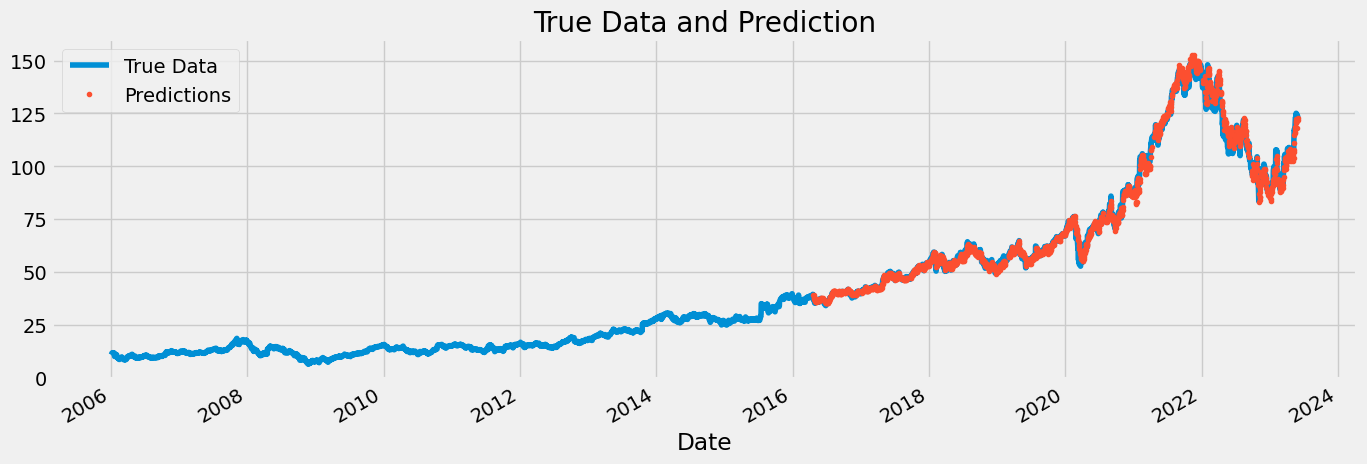

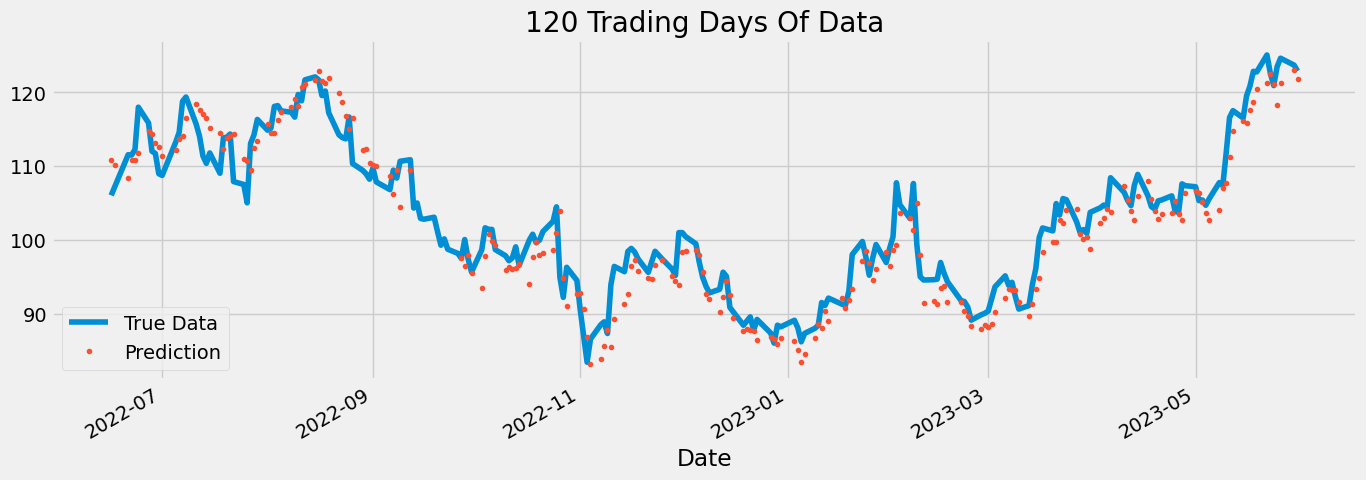

In [5]:
# Visualize results
print(f'RMSE across folds {np.mean(scores_cnn):0.4f}')
print(f'Fold RMSE: {scores_cnn}')
plot_predictions(df, preds_cnn)

In [6]:
# Train and evaluate the LSTM model
lstm_features = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag day high', 'lag day low', 'lag day open',
            'lag quarter close', 'SMA', 'EMA', 'MACD', 'RSI',
            'Upper_band', 'Lower_band', 'MFI', 'ATR', 'ForceIndex', 'EMV']
lstm_target = 'Close'
lstm_timestep = 10
lstm_input_shape = (lstm_timestep, len(lstm_features))

lstm_model = Sequential()
lstm_model.add(LSTM(units=64, return_sequences=False, input_shape=lstm_input_shape))
lstm_model.add(Dense(units=32))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['root_mean_squared_error'])

print("Training LSTM Model...")
preds_lstm, scores_lstm = train_and_evaluate(model=lstm_model, df=df, seq_length=lstm_timestep,
                                             batch_size=64, epochs=100, features=lstm_features,
                                             target=lstm_target, n_splits=5, test_size=180) 



/Users/School/Documents/Github/ML_StockPriceForcasting/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Training LSTM Model...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
RMSE across folds 1.5947
Fold RMSE: [1.5946955106922927]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
RMSE across folds 1.8115
Fold RMSE: [1.5946955106922927, 2.0283475938780704]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE across folds 2.7335
Fold RMSE: [1.5946955106922927, 2.0283475938780704, 4.57756649498919]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE across folds 3.8059
Fold RMSE: [1.5946955106922927, 2.0283475938780704, 4.57756649498919, 7.0228779575160925]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
RMSE across folds 3.5922
Fold RMSE: [1.5946955106922927, 2.0283475938780704, 4.57756649498919, 7.0228779575160925, 2.7376926212790265]


RMSE across folds 3.5922
Fold RMSE: [1.5946955106922927, 2.0283475938780704, 4.57756649498919, 7.0228779575160925, 2.7376926212790265]


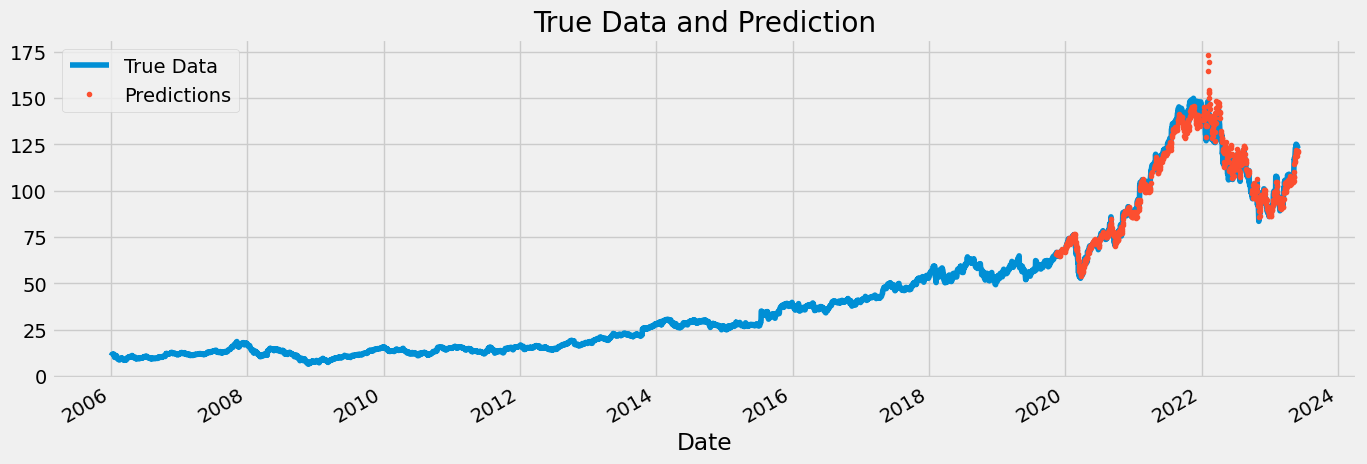

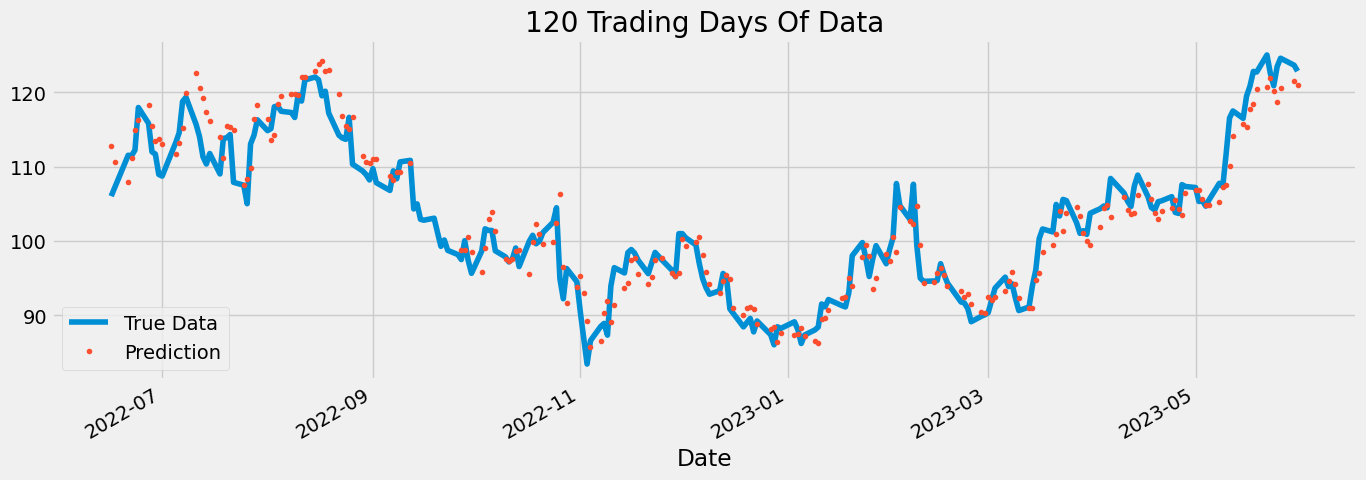

In [7]:
# Visualize results
print(f'RMSE across folds {np.mean(scores_lstm):0.4f}')
print(f'Fold RMSE: {scores_lstm}')
plot_predictions(df, preds_lstm)

In [8]:
# Define features and target for GRU
gru_features = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag day high', 'lag day low', 'lag day open',
            'lag quarter close', 'SMA', 'EMA', 'MACD', 'RSI',
            'Upper_band', 'Lower_band', 'MFI', 'ATR', 'ForceIndex', 'EMV']
gru_target = 'Close'
gru_timestep = 10
gru_input_shape = (gru_timestep, len(gru_features))

gru_model = Sequential()
gru_model.add(GRU(64, return_sequences=False, input_shape=gru_input_shape))
gru_model.add(Dense(32))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['root_mean_squared_error'])

# Train and evaluate the GRU model
print("Training GRU Model...")
preds_gru, scores_gru = train_and_evaluate(gru_model, df, seq_length=gru_timestep,
                                           batch_size=64, epochs=100, features=gru_features,
                                           target=gru_target, n_splits=5, test_size=180)



/Users/School/Documents/Github/ML_StockPriceForcasting/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Training GRU Model...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
RMSE across folds 1.7941
Fold RMSE: [1.7941209192840588]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE across folds 1.9093
Fold RMSE: [1.7941209192840588, 2.0245050653825136]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE across folds 2.3571
Fold RMSE: [1.7941209192840588, 2.0245050653825136, 3.252657989973706]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE across folds 3.3165
Fold RMSE: [1.7941209192840588, 2.0245050653825136, 3.252657989973706, 6.194816230879807]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[features] = scaler_features.fit_transform(train[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[features] = scaler_features.transform(test[features])
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_34770/190858725.py:325: SettingWithCopyWarning: 
A value is trying to b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
RMSE across folds 3.2587
Fold RMSE: [1.7941209192840588, 2.0245050653825136, 3.252657989973706, 6.194816230879807, 3.0273679694419577]


RMSE across folds 3.2587
Fold RMSE: [1.7941209192840588, 2.0245050653825136, 3.252657989973706, 6.194816230879807, 3.0273679694419577]


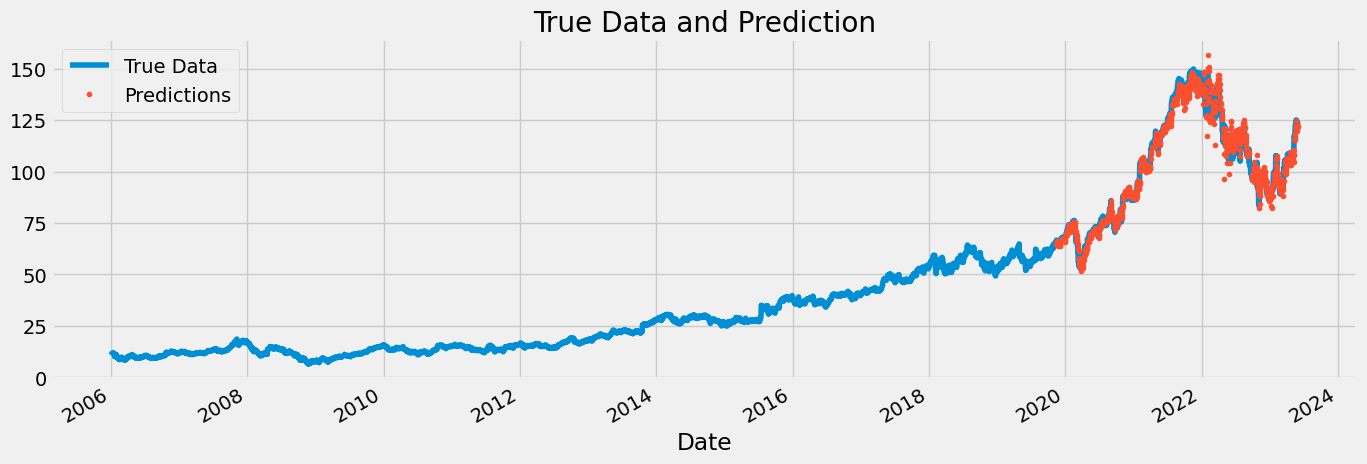

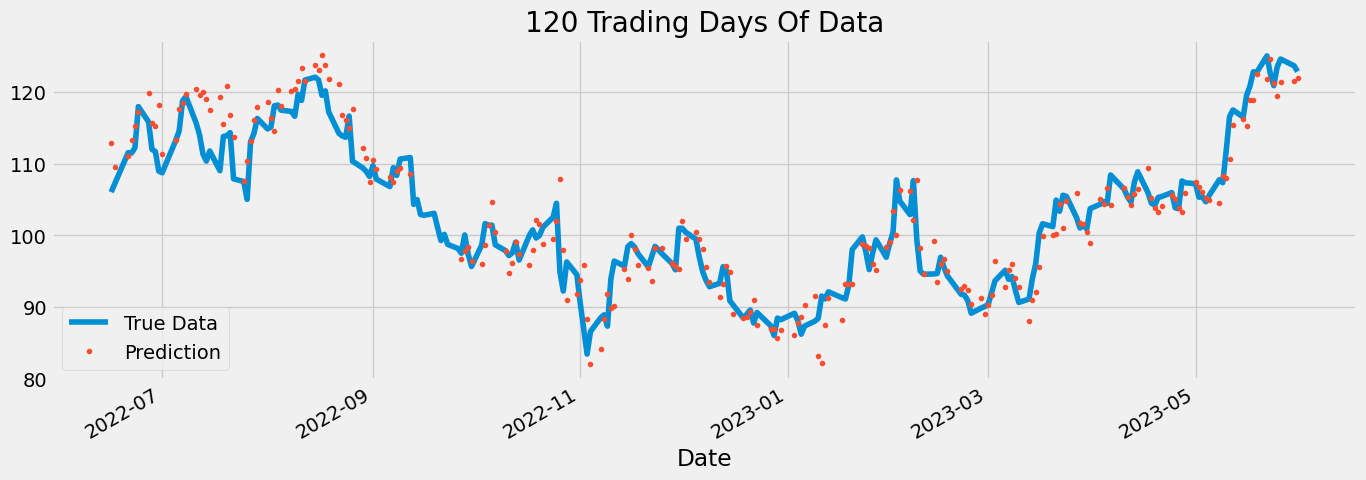

In [9]:
# Visualize results
print(f'RMSE across folds {np.mean(scores_gru):0.4f}')
print(f'Fold RMSE: {scores_gru}')
plot_predictions(df, preds_gru) 